In [101]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

data = pd.read_excel('BBDD ONSV SINIESTROS 2021-2022.xlsx')

In [ ]:
# Extraer los valores únicos de las columnas relevantes para definir el índice de gravedad
categorias_tipo_siniestro = data['TIPO_SINIESTRO'].unique()
categorias_condicion_climatica = data['CONDICION_CLIMATICATICA'].unique()
categorias_superficie_calzada = data['SUPERFICIE_CALZADA'].unique()
categorias_caracteristicas_via = data['CARACTERÍSTICAS_VIA'].unique()

(categorias_tipo_siniestro, categorias_condicion_climatica, categorias_superficie_calzada, categorias_caracteristicas_via)

In [104]:
def calcular_gravedad(row):
    # Diccionarios de puntuación para cada característica

    puntuacion_tipo_siniestro = {
        'CHOQUE': 3, 'DESPISTE': 3,
        'ATROPELLO': 2, 'ATROPELLO FUGA': 2, 'VOLCADURA': 2, 'INCENDIO': 2,
        'CHOQUE FUGA': 1, 'CHOQUE CON OBJETO FIJO': 1, 'CAÍDA DE PASAJERO': 1, 'ESPECIAL': 1, 'FERROVIARIO': 1
    }
    #puntuacion_tipo_siniestro = {
        #'ATROPELLO': 3, 'ATROPELLO FUGA': 3,
        #'DESPISTE': 2, 'VOLCADURA': 2, 'CHOQUE CON OBJETO FIJO': 2, 'INCENDIO': 2,
        #'CHOQUE': 1, 'CHOQUE FUGA': 1, 'CAÍDA DE PASAJERO': 1, 'ESPECIAL': 1, 'FERROVIARIO': 1
    #}
    puntuacion_condicion_climatica = {
        'NUBLADO': 2, 'NIEBLA': 2, 'LLUVIOSO': 2,
        'DESPEJADO': 1, 'SOLEADO': 1,
        'GRANIZADO': 0
    }
    puntuacion_superficie_calzada = {
        'TROCHA': 2, 'CASCAJO/RIPIO': 2, 'ADOQUINADO': 2, 'EMPEDRADO': 2,
        'AFIRMADO': 1, 'CONCRETO': 1, 'ASFALTADA': 1
    }
    puntuacion_caracteristicas_via = {
        'INTERSECCIÓN': 2, 'CURVA': 2, 'ÓVALO': 2, 'PUENTE': 2, 'TÚNEL': 2, 'PASE A DESNIVEL': 2,
        'TRAMO RECTO': 1, 'SINUOSA': 1, 'OTRO': 1
    }

    # Calcular la puntuación de gravedad
    score = 0
    score += puntuacion_tipo_siniestro.get(row['TIPO_SINIESTRO'], 0)
    score += puntuacion_condicion_climatica.get(row['CONDICION_CLIMATICATICA'], 0)
    score += puntuacion_superficie_calzada.get(row['SUPERFICIE_CALZADA'], 0)
    score += puntuacion_caracteristicas_via.get(row['CARACTERÍSTICAS_VIA'], 0)

    return score

# Aplicar la función al dataframe para crear la columna 'Gravedad'
data['Gravedad'] = data.apply(calcular_gravedad, axis=1)

# Mostrar las primeras filas del dataframe para verificar la nueva columna
data[['TIPO_SINIESTRO', 'CONDICION_CLIMATICATICA', 'SUPERFICIE_CALZADA', 'CARACTERÍSTICAS_VIA', 'Gravedad']].head()

,TIPO_SINIESTRO,CONDICION_CLIMATICATICA,SUPERFICIE_CALZADA,CARACTERÍSTICAS_VIA,Gravedad
0,CHOQUE,LLUVIOSO,CONCRETO,INTERSECCIÓN,8
1,DESPISTE,DESPEJADO,TROCHA,TRAMO RECTO,7
2,DESPISTE,DESPEJADO,ASFALTADA,TRAMO RECTO,6
3,ATROPELLO,DESPEJADO,ASFALTADA,TRAMO RECTO,5
4,ATROPELLO FUGA,DESPEJADO,ASFALTADA,TRAMO RECTO,5


In [ ]:
data.head()

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identificar variables categóricas y numéricas
categorical_vars = ['TIPO_SINIESTRO', 'CONDICION_CLIMATICATICA', 'SUPERFICIE_CALZADA', 'CARACTERÍSTICAS_VIA', 'DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'ZONA', 'TIPO_VIA', 'RED_VIAL', 'CICLOVIA', 'ZONIFICACION']
numerical_vars = ['HORA_SINIESTRO','CANTIDAD_HERIDOS']  # Suponemos que 'HORA_SINIESTRO' es numérica, se verificará y convertirá si es necesario

# Convertir la hora a un formato numérico (hora del día en minutos)
data['HORA_SINIESTRO'] = pd.to_datetime(data['HORA_SINIESTRO'], format='%H:%M').dt.hour * 60 + pd.to_datetime(data['HORA_SINIESTRO'], format='%H:%M').dt.minute

# Preprocesamiento con pipelines
# OneHotEncoder para variables categóricas y StandardScaler para variables numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_vars),
        ('cat', OneHotEncoder(), categorical_vars)
    ])

# Crear el pipeline de preprocesamiento y ajustar-transformar los datos
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
data_prepared = pipeline.fit_transform(data)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    data_prepared, data['Gravedad'], test_size=0.2, random_state=42
)

# Verificar las dimensiones de los conjuntos de entrenamiento y prueba
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((3884, 1186), (971, 1186), (3884,), (971,))

In [106]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
#from sklearn.model_selection import cross_val_score

dt_classifier = DecisionTreeClassifier(random_state=42)

# Entrenar el modelo
dt_classifier.fit(X_train, y_train)

# Predecir las etiquetas del conjunto de prueba
y_pred = dt_classifier.predict(X_test)

# Calcular y mostrar la exactitud del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud del modelo:", accuracy)

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n", conf_matrix)

# Mostrar un informe de clasificación
report = classification_report(y_test, y_pred)
print("Informe de clasificación:\n", report)

Exactitud del modelo: 0.9773429454170958
Matriz de confusión:
 [[ 36   0   1   0   0   0]
 [  0 243   1   0   0   0]
 [  0   3 387   5   2   0]
 [  0   4   3 199   1   2]
 [  0   0   0   0  62   0]
 [  0   0   0   0   0  22]]
Informe de clasificación:
               precision    recall  f1-score   support

           4       1.00      0.97      0.99        37
           5       0.97      1.00      0.98       244
           6       0.99      0.97      0.98       397
           7       0.98      0.95      0.96       209
           8       0.95      1.00      0.98        62
           9       0.92      1.00      0.96        22

    accuracy                           0.98       971
   macro avg       0.97      0.98      0.97       971
weighted avg       0.98      0.98      0.98       971



0.9309989701338826
[[ 32   1   4   0   0   0]
 [  3 232   7   2   0   0]
 [  0  10 380   4   3   0]
 [  0   0  18 190   0   1]
 [  0   0   0  12  50   0]
 [  0   0   0   1   1  20]]


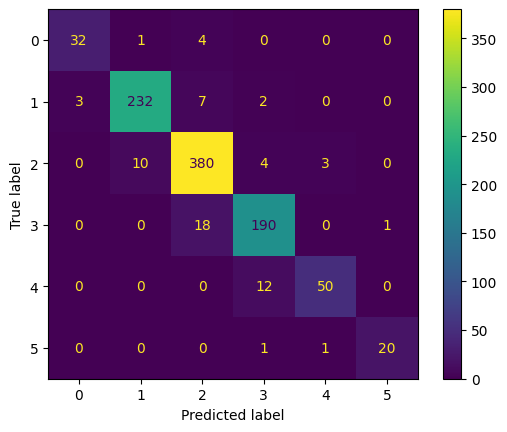

In [107]:
from sklearn.ensemble import RandomForestClassifier

# Inicializar el RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_classifier.fit(X_train, y_train)

# Predecir las etiquetas del conjunto de prueba
y_pred = rf_classifier.predict(X_test)

# Calcular la exactitud del modelo
accuracy = accuracy_score(y_test, y_pred)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar la exactitud y la matriz de confusión
accuracy, conf_matrix

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

#matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm_rf)
disp.plot()
plt.show()

Confusion Matrix:
 [[ 36   1   0   0   0   0]
 [  2 237   5   0   0   0]
 [  0   7 382   5   3   0]
 [  0   0   7 196   4   2]
 [  0   0   0   8  54   0]
 [  0   0   0   0   2  20]]
Classification Report:
               precision    recall  f1-score   support

           4       0.95      0.97      0.96        37
           5       0.97      0.97      0.97       244
           6       0.97      0.96      0.97       397
           7       0.94      0.94      0.94       209
           8       0.86      0.87      0.86        62
           9       0.91      0.91      0.91        22

    accuracy                           0.95       971
   macro avg       0.93      0.94      0.93       971
weighted avg       0.95      0.95      0.95       971



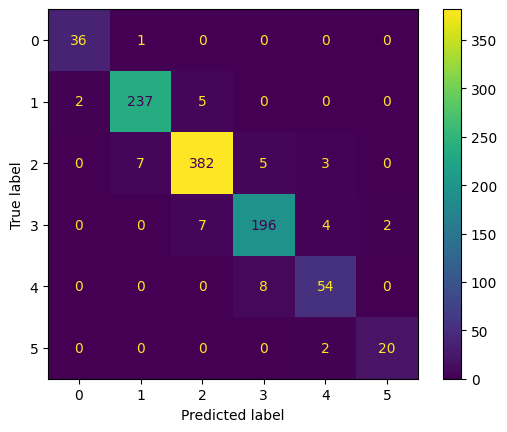

In [108]:
from sklearn.ensemble import GradientBoostingClassifier

# Configuración y entrenamiento del modelo Gradient Boosting
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

gb_classifier.fit(X_train, y_train)

# Mostrar la exactitud y la matriz de confusión
accuracy, conf_matrix

# Predicción y evaluación del modelo
y_pred = gb_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
classif_report = classification_report(y_test, y_pred)

# Imprimir los resultados de la evaluación
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classif_report)

#matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm_rf)
disp.plot()
plt.show()

In [66]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Definir los modelos a evaluar
models = {
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42)
}

# Datos preparados previamente (X) y etiquetas (y)
X = data_prepared  # Asegúrate de que 'data_prepared' es tu conjunto de datos transformado
y = data['Gravedad']  # Asegúrate de que 'data' contiene tu columna 'Gravedad'

# Realizar la validación cruzada para cada modelo
for name, model in models.items():
    cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"Resultados para {name}:")
    print("  - Media de exactitud:", cross_val_scores.mean())
    print("  - Desviación estándar de exactitud:", cross_val_scores.std())
    print("  - Puntuaciones de validación cruzada:", cross_val_scores)
    print("\n")

Resultados para DecisionTreeClassifier:
  - Media de exactitud: 0.9794026776519053
  - Desviación estándar de exactitud: 0.006923887256013023
  - Puntuaciones de validación cruzada: [0.96807415 0.97940268 0.98970134 0.97837281 0.98146241]


Resultados para RandomForestClassifier:
  - Media de exactitud: 0.9227600411946447
  - Desviación estándar de exactitud: 0.016695270137309516
  - Puntuaciones de validación cruzada: [0.90834192 0.91967044 0.92893924 0.90525232 0.95159629]


Resultados para GradientBoostingClassifier:
  - Media de exactitud: 0.9470648815653965
  - Desviación estándar de exactitud: 0.011589540594550122
  - Puntuaciones de validación cruzada: [0.93717817 0.9392379  0.95674562 0.93717817 0.96498455]




In [ ]:

importances = rf_classifier.feature_importances_
feature_names = list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out())
feature_names.extend(numerical_vars)  # Agregar nombres de variables numéricas si es necesario

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importance_df['Variable'] = importance_df['Feature'].apply(lambda x: x.split('_')[0])
importance_summary = importance_df.groupby('Variable')['Importance'].sum().sort_values(ascending=False)

print(importance_summary.head(10))

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Variables categóricas a codificar
categorical_features = [
    'TIPO_SINIESTRO', 'CONDICION_CLIMATICATICA', 'CARACTERÍSTICAS_VIA', 'SUPERFICIE_CALZADA'
]

# Preparación de las transformaciones para las variables categóricas
categorical_transformer = OneHotEncoder()

# Creación del transformador de columnas para aplicar las transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear un pipeline que incluye el preprocesador y el escalador
clustering_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False))  # with_mean=False para sparse data después de OneHotEncoding
])

# Ajustar y transformar los datos
data_prepared = clustering_pipeline.fit_transform(data)

data_prepared.shape, data_prepared.dtype

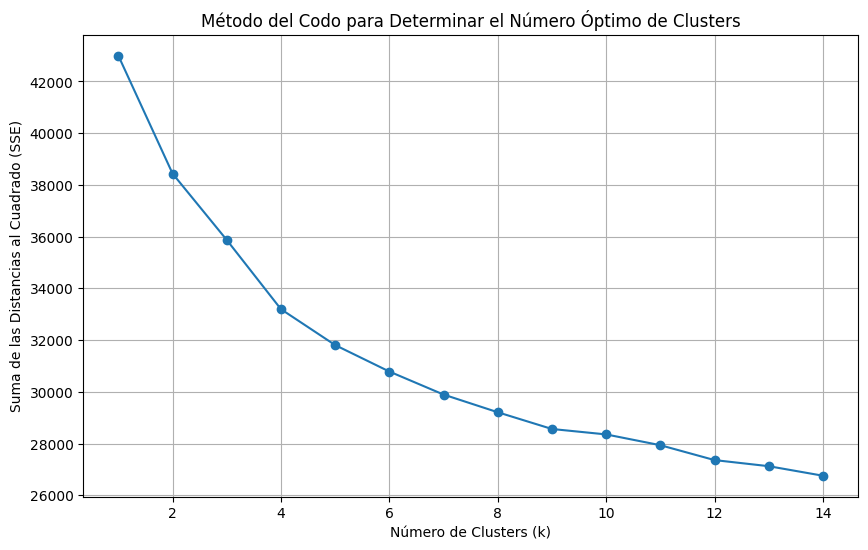

In [109]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Definir el rango de número de clusters a evaluar
k_values = range(1, 15)
sse = []

# Calcular la suma de cuadrados de las distancias para cada valor de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_prepared)
    sse.append(kmeans.inertia_)

# Graficar la suma de cuadrados de las distancias (SSE) vs el número de clusters (K)
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.title('Método del Codo para Determinar el Número Óptimo de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Suma de las Distancias al Cuadrado (SSE)')
plt.grid(True)
plt.show()



In [110]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Aplicar K-means con k=6
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(data_prepared)

# Agregar los labels de clusters al dataframe original para análisis
data_with_clusters = data.copy()
data_with_clusters['Cluster'] = clusters

# Agrupar por cluster y calcular estadísticas descriptivas para cada grupo
cluster_summary = data_with_clusters.groupby('Cluster').agg({
    'TIPO_SINIESTRO': pd.Series.mode,  # Moda de tipo de siniestro
    'CONDICION_CLIMATICATICA': pd.Series.mode,  # Moda de condiciones climáticas
    'CARACTERÍSTICAS_VIA': pd.Series.mode,  # Moda de características de vía
    'SUPERFICIE_CALZADA': pd.Series.mode,  # Moda de superficie de calzada
    'CANTIDAD_HERIDOS': 'mean',  # Promedio de heridos
})

cluster_summary

,TIPO_SINIESTRO,CONDICION_CLIMATICATICA,CARACTERÍSTICAS_VIA,SUPERFICIE_CALZADA,CANTIDAD_HERIDOS
Cluster,,,,,
0,DESPISTE,DESPEJADO,CURVA,TROCHA,1.221929
1,CHOQUE,DESPEJADO,TRAMO RECTO,ASFALTADA,0.565015
2,ATROPELLO,DESPEJADO,TRAMO RECTO,ASFALTADA,0.589056
3,CHOQUE,DESPEJADO,TRAMO RECTO,ASFALTADA,0.758002
4,CHOQUE,DESPEJADO,TRAMO RECTO,ASFALTADA,0.725376
5,DESPISTE,DESPEJADO,TRAMO RECTO,ASFALTADA,21.170732


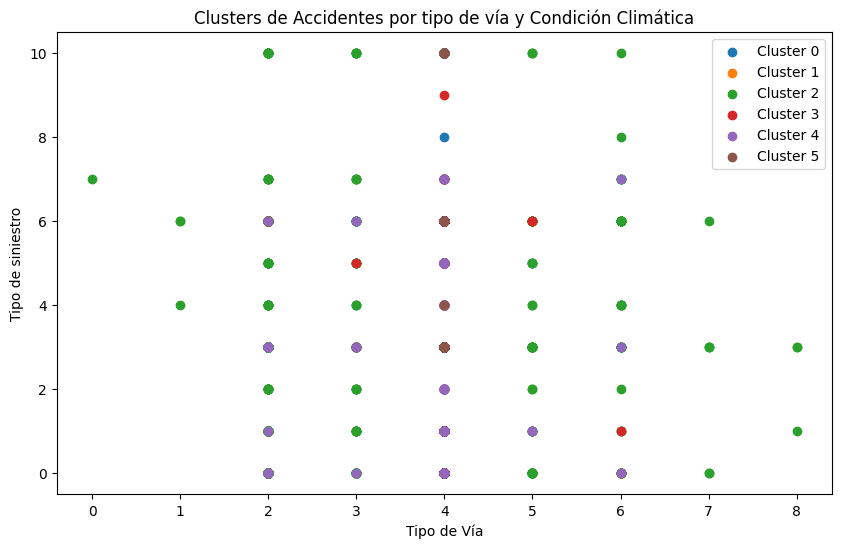

In [112]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# El número de clusters se elige arbitrariamente
clusters = kmeans.fit_predict(data_prepared)

# Añadir los clusters al dataframe original para análisis
data['Cluster'] = clusters

# Visualización de los clusters
plt.figure(figsize=(10, 6))

for i in range(kmeans.n_clusters):
    plt.scatter(data.loc[data['Cluster'] == i, 'TIPO_VIA'], data.loc[data['Cluster'] == i, 'TIPO_SINIESTRO'], label=f'Cluster {i}')
plt.title('Clusters de Accidentes por tipo de vía y Condición Climática')
plt.xlabel('Tipo de Vía')
plt.ylabel('Tipo de siniestro')
plt.legend()
plt.show()